### Lab_1

Для Домашней работы 2, колонки:`banner_id0`, `banner_id1`, `rate0`, `rate1`, `g0`, `g1`, `coeff_sum0`, `coeff_sum1` использовать не нужно. Они будут использоваться в последующих Домашних работах.

- date_time - время показа рекламы
- zone_id - id зоны, где зона - место на сайте для размещения рекламы
- banner_id - id баннера, где баннер - сама реклама
- campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
- os_id - id операционной системы
- country_id - id страны
- impressions - был ли показ
- clicks - был ли клик

Task:
- Проанализируйте данные и подберите/сконструируйте осмысленные фичи.
- Постройте модель, которая предсказывает вероятность клика.
- Подберите для построенной модели регуляризацию. В качестве метрики считайте log-loss и auc.
- Свою итоговую модель примените к последнему дню датасета и вычислите log-loss и auc. Это будет неким ответом к домашней работе.
- Проверить, что ваше модель хорошая, нужно сравнив ее с бейзлайном (например, предикт среднего по выборке).
- Максимальный балл можно получить за использование не SGD-like оптимизатора. https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/#h-rprop-class


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Изначальные данные и работа с ними:

Так как некоторые features не нужно использовать в данной домашней работе - удалим их.

In [2]:
data = pd.read_csv('/kaggle/input/data-1/data.csv').sample(200000).drop(['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], axis=1)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
7492076,2021-10-02 16:29:27.000000,14,530,4142332603364385759,0,2,9,1,0
3882120,2021-10-02 21:05:15.000000,19,1233,8327568436151012422,0,1,0,1,0
12814932,2021-10-02 15:51:06.000000,664,1008,5237283552061754297,0,2,5,1,0
10007294,2021-09-26 02:43:34.000000,2,1238,8910935923757873916,0,4,0,1,0
10108280,2021-09-27 05:01:27.000000,32,29,3145875849833769095,0,3,1,1,0


### FM:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
!pip install xlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for xlearn: filename=xlearn-0.40a1-py3-none-any.whl size=225725 sha256=4c011a50cad65a309e9c0f94afc72e66f7fe02457630f8f6407e416b20a313c7
  Stored in directory: /root/.cache/pip/wheels/09/48/04/779ee06b22532c86cde8da8984b83284517492dad1df998c6a
Successfully built xlearn


In [5]:
from tqdm import tqdm
import xlearn as xl

In [6]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    categ = [ 'zone_id', 'banner_id', 'oaid_hash' , 'os_id', 'country_id', 'hour', 'month', 'day']
    data = data.drop(['impressions'], axis=1)
    data['hour'], data['month'], data['day'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.hour, \
                                              pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.month, \
                                              pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.day
    data.drop_duplicates(inplace=True)
    condition_zone_id = data['zone_id'].value_counts()
    new_zone = condition_zone_id[condition_zone_id <= 3000].index
    data['zone_id'] = data['zone_id'].apply(lambda x: 0 if x in new_zone else x)
    for col in categ:
        if col == 'os_id':
            data.loc[data['os_id'] > 7, 'os_id'] = 7
        elif col != "oaid_hash":
            column = data[col].value_counts()
            mask_obs = column[column < column.sum() * 0.0001].index
            mask = data[col].isin(mask_obs)
            data.loc[mask, col] = 0
    for col in categ:
        data[col], _ = pd.factorize(data[col])
    return data

data = feature_engineering(data)
data.tail()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks,hour,month,day
5893063,2021-09-30 09:48:42.000000,2,128,185217,0,5,4,0,22,1,5
5894992,2021-09-29 07:22:05.000000,4,5,185218,0,1,4,0,12,1,3
11981087,2021-09-26 11:26:19.000000,2,140,15601,1,0,10,0,9,1,1
2034931,2021-09-27 00:26:18.000000,2,506,185219,0,1,1,0,15,1,2
1512198,2021-09-29 12:14:35.000000,2,14,185220,0,5,0,0,20,1,3


In [7]:
# разделим данные на тренировочную и тестовую выборку, возьмем только часть данных, чтобы быстрее обучалось и работало

test_data = data[pd.to_datetime(data['date_time']) == '2021-10-02']
print(f"Кол-во тестовых данных: {len(test_data)}")
data.drop(index=test_data.index, inplace=True)
test_data.reset_index(inplace=True)
data.reset_index(inplace=True)
X_test, y_test = test_data.drop(['clicks', 'date_time'], axis=1), test_data['clicks']
print(f"Классы в y_test: {y_test.unique()}")

data = data.drop(['date_time'], axis=1)

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

Кол-во тестовых данных: 0
Классы в y_test: []


In [8]:
categ = ["zone_id", "banner_id", "oaid_hash", "os_id", "country_id", "hour", "month", "day"]

def transform_to_libffm(filename, data, target, dict_field, c=0):
    with open(filename, "w") as f:
        for index, row in tqdm(data.iterrows()):
            result_row = str(row[target])
            for i, x in enumerate(categ):
                if (x not in dict_field):
                    dict_field[x] = {}
                    c += 1
                    dict_field[x][row[x]] = c
                elif (row[x] not in dict_field[x]):
                    c += 1
                    dict_field[x][row[x]] = c
                result_row += f' {i}:{dict_field[x][row[x]]}:1'
            result_row += '\n'
            f.write(result_row)
    return c, dict_field

In [9]:
c = 0
dict_field = {}
с, dict_field = transform_to_libffm("./train.txt", data_train, 'clicks', dict_field, c)
с, dict_field = transform_to_libffm("./val.txt", data_val, 'clicks', dict_field, с)
с, dict_field = transform_to_libffm("./test.txt", test_data, 'clicks', dict_field, с)

159988it [00:19, 8349.59it/s]
39998it [00:04, 8395.83it/s]
0it [00:00, ?it/s]


In [1]:
y_val = data_val['clicks'].values

roc_auc_scores = []
log_losses = []

for l in [0.01, 0.001, 0.0001]:
    for k in [2, 4, 8]:
        ffm_model = xl.create_ffm()
        ffm_model.setTrain("./train.txt")
        ffm_model.setTest("./val.txt")
        param = {'task':'binary', 'lr': 0.1, 'lambda': l, 'k': k, 'metric': 'auc'}

        ffm_model.fit(param, './model.out')
        ffm_model.setSigmoid()
        ffm_model.predict('./model.out', './result.txt')

        with open('rusult.txt', 'r') as f:
            y_pred_proba = np.array(list(map(float, filter(lambda s: len(s) > 0, f.read().split('\n')))))
        roc_auc_scores.append([l, k, roc_auc_score(y_val, y_pred_proba)])
        log_losses.append([l, k, log_loss(y_val, y_pred_proba)])

NameError: name 'data_val' is not defined

In [ ]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train.txt")
ffm_model.setTest("./test.txt")
param = {'task':'binary', 'lr': 0.1, 'lambda': 0.01, 'k': 4, 'metric': 'auc'}

ffm_model.fit(param, './model.out')
ffm_model.setSigmoid()
ffm_model.predict('./model.out', './rusult.txt')

with open('./res.txt', 'r') as f:
    y_pred_proba = np.array(list(map(float, filter(lambda s: len(s) > 0, f.read().split('\n')))))

    roc_auc_metric = roc_auc_score(y_test, y_pred_proba)
log_loss_metric = log_loss(y_test, y_pred_proba)
print(f'roc_auc = {roc_auc_metric}, log_loss = {log_loss_metric}')

In [ ]:
baseline = data.clicks.value_counts()[1] / data.clicks.count() # средняя вероятность клика
baseline

0.06447902790030967

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

Accuracy: 0.9358

Log Loss: 0.2317

ROC AUC: 0.6374


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:

               precision    recall  f1-score   support



           0       0.94      1.00      0.97    584021

           1       0.00      0.00      0.00     40080



    accuracy                           0.94    624101

   macro avg       0.47      0.50      0.48    624101

weighted avg       0.88      0.94      0.90    624101




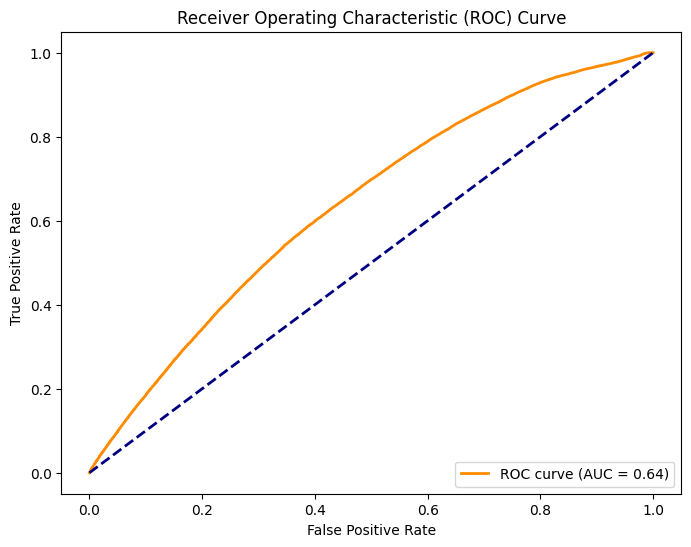

baseline 0.06447902790030967


In [ ]:
def create_model(data: pd.DataFrame):
    y, X =  data['clicks'], data.drop(['clicks'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(solver='liblinear', max_iter=2000, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_probab = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_probab)
    roc_auc = roc_auc_score(y_test, y_probab)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    print("Classification Report:\n", classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_probab)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print('baseline', data.clicks.value_counts()[1] / data.clicks.count()) # средняя вероятность клика)
create_model(data)

In [ ]:
# ohe = OneHotEncoder(sparse=False)
#one_hot_os = pd.get_dummies(data['os_id'])
#one_hot_country = pd.get_dummies(data['country_id'])
#data = data.join(one_hot_country, one_hot_os)
# data = data.join(one_hot_os)
#data.drop(['os_id', 'country_id'], axis=1)

In [ ]:
def cv(data: pd.DataFrame):
    pass